In [2]:

import cv2
from skimage.transform import resize
from models.Unet import UNet
from dataset.data import BatchMaker
from utils.metrics import SegmentationMetrics
from utils.augmentation import MyAugmentation
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt


In [3]:
BATCH = 1
path_to_config = '/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Kod/config/config_laptop.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)
model_path = config['save_model_path'] + '/mixedGT1_best_model'


annotator1 = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'all',segment = 'mixed',annotator= 1)
train_GT1 = annotator1.train_loader

FileNotFoundError: [Errno 2] No such file or directory: '/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Kod/config/config_laptop.yaml'

In [ ]:
augmentation = MyAugmentation()

for batch_idx, (inputs, labels,ids) in enumerate(train_GT1):
    if batch_idx == 11:
        break
    for i in range(1):
        inputs[i], labels[i] = augmentation(inputs[i], labels[i])
        plt.subplot(1,2,1)
        plt.imshow(inputs[i].permute(1,2,0))
        plt.subplot(1,2,2)
        plt.imshow(labels[i])
        plt.show()

In [ ]:
import cv2

input = cv2.imread('/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/train/GT1_full/0.png')
input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

Number = 416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])


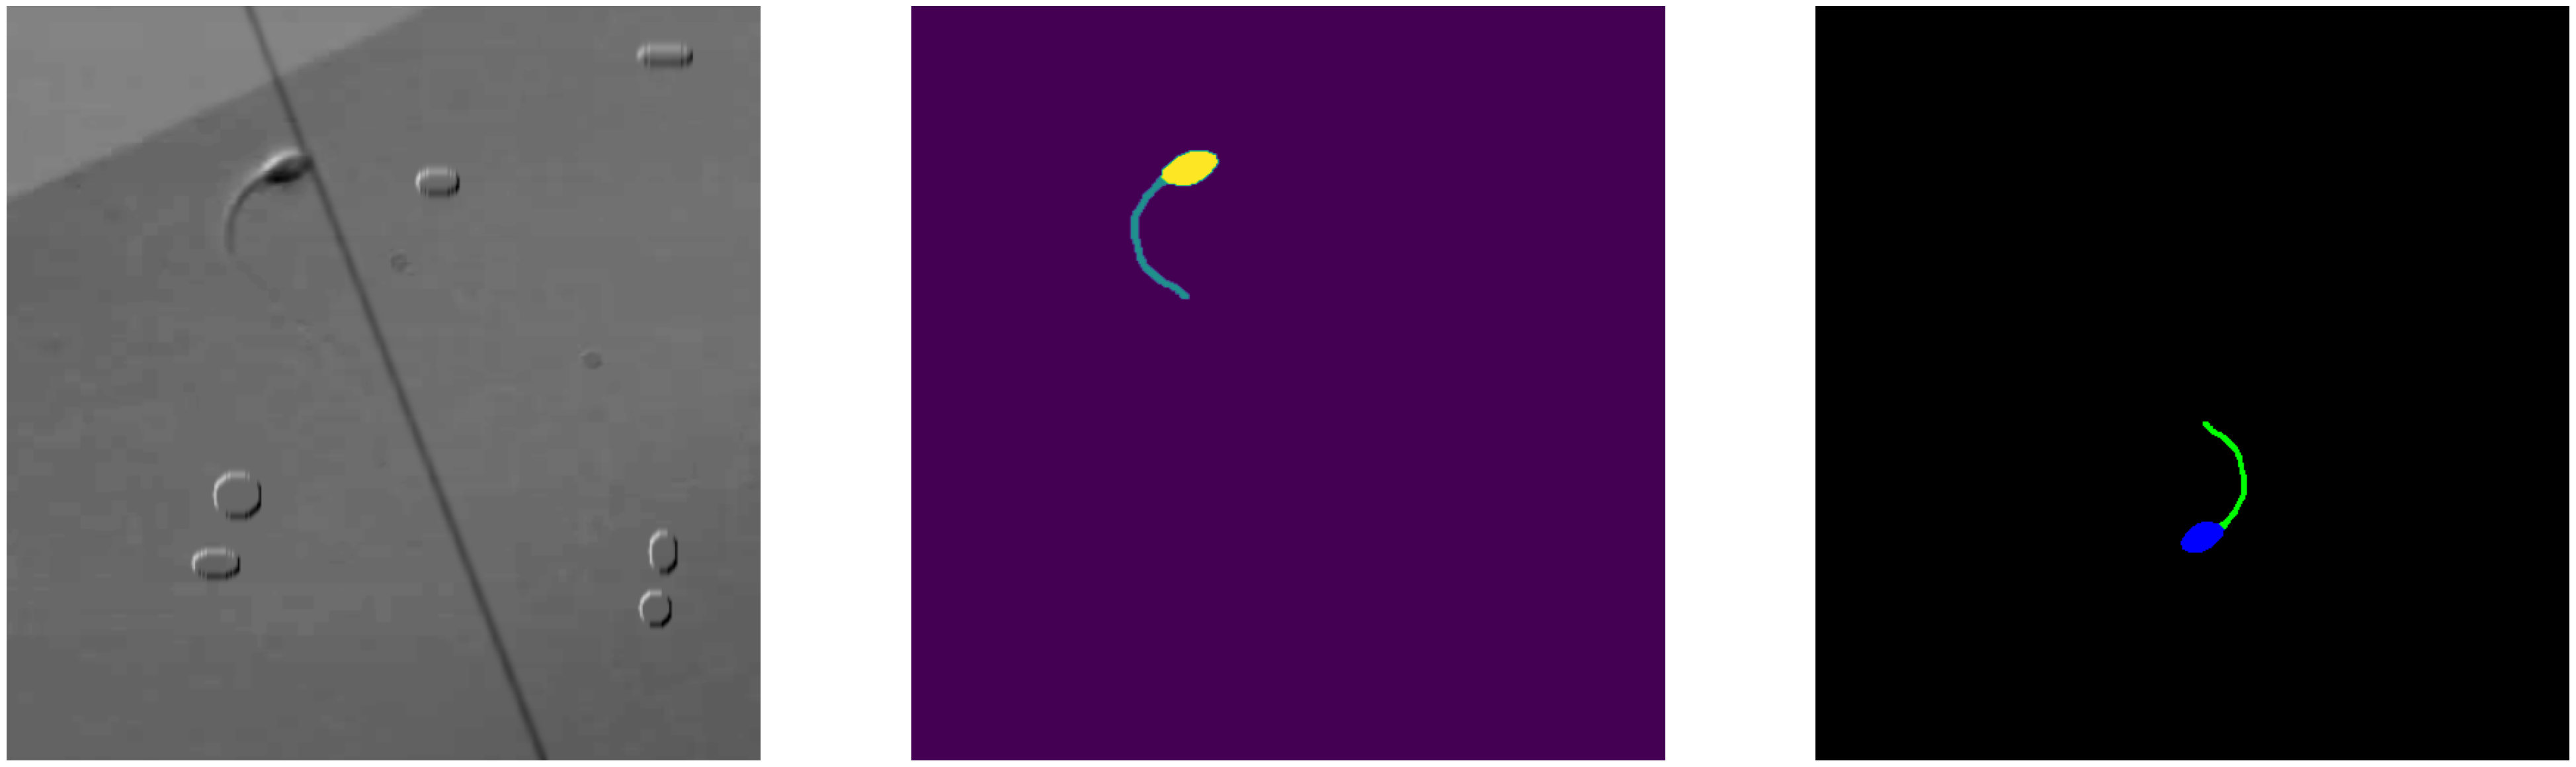

In [8]:
import cv2
from skimage.transform import resize
from models.Unet import UNet
from dataset.data import BatchMaker
from utils.metrics import SegmentationMetrics
from utils.augmentation import MyAugmentation
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random

def rgb_to_class_id(mask_rgb, class_colors):
        mask_id = np.zeros(mask_rgb.shape[:2], dtype=np.float32)
        for class_id, color in enumerate(class_colors):
            mask_id[(mask_rgb == color).all(axis=2)] = class_id
        return mask_id

class_colors = [[0, 0, 0], [0, 255, 0], [0, 0, 255]]  # tło, wić, główka
number = random.randint(0, 431)
print(f'Number = {number}')

img = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/images/{number}.png')
x_img = img.astype(np.float32)
x_img = resize(x_img, (512, 512, 3), mode='constant', preserve_range=True)


        
# Load masks
mask = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/GT1_mixed/{number}.png')
mask = mask.astype(np.float32)
mask = resize(mask, (512, 512, 3), mode='constant', preserve_range=True)
mask_id = rgb_to_class_id(mask, class_colors)

hmask = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/GT1_head/{number}.png')
hmask = mask.astype(np.float32)
hmask = resize(hmask, (512, 512, 1), mode='constant', preserve_range=True)
#hmask_id = rgb_to_class_id(hmask, class_colors)
min_val = np.min(x_img)
max_val = np.max(x_img)
x_img = (x_img - min_val) / (max_val - min_val)


x_img = x_img.transpose(2, 0, 1)
x_img = torch.from_numpy(x_img)
mask_id = torch.from_numpy(mask_id)


augmentation = MyAugmentation()
x_img,mask_id = augmentation(x_img, mask_id)

#mask_id = mask_id.squeeze(0)
print(mask_id.shape)


plt.figure(figsize=(50, 50))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(x_img[0].permute(1,2,0))
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(mask_id[0].permute(1,2,0))
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(mask)

plt.show()
